### Target data distribution p1(x1), original code used a checkerboard sampling method, replace with actual target data 

Data preparation (cell 2): Now keeps only tail data and normalizes HiggsM values for conditioning.

Model (cell 7): ConditionalMLP now accepts three inputs:

x: frequency data
t: time step
cond: normalized HiggsM value
The HiggsM conditioning information is projected and added to the network, allowing the model to learn how the velocity field varies with HiggsM.

Training (cell 9): Now passes the corresponding HiggsM value for each frequency sample during training.

Sampling (cell 12): Samples across the entire HiggsM range including the pole region. The model uses learned patterns from tail data to extrapolate predictions into the pole region where it has no direct training data.

The key insight: the model learns "how frequencies behave at this HiggsM value" from the tails, then applies that learned pattern to generate predictions in the pole region.

Tail data shape: (700, 2)
HiggsM range: 104998 to 159975
Frequency range: 6099 to 22530
Number of tail points: 700


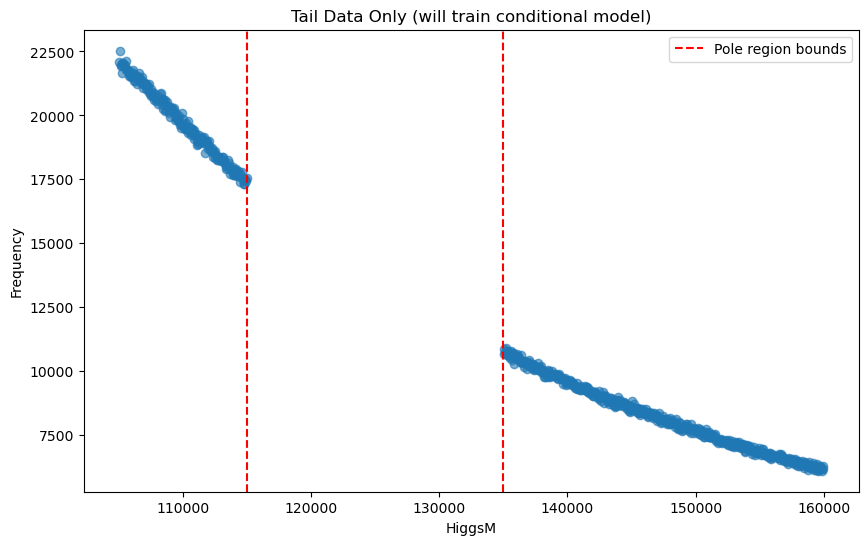

In [2]:
import tqdm
import math
import torch
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

raw_df = pd.read_hdf('data_files/new_Input_NonResonant_yy_25th_January2026.h5', key='VBF_Polarisation_Tree')

# Define bounds and number of bins
lower_bound = 115000
upper_bound = 135000
num_bins = 1100

# Creating frequency distribution for HiggsM
freq = pd.cut(raw_df['HiggsM'], bins=num_bins)
freq_counts = freq.value_counts().sort_index()
higgsM_values = [interval.mid for interval in freq_counts.index]
frequencies = freq_counts.values.tolist()

# Create DataFrame for ML Model
model_df = pd.DataFrame({'HiggsM': higgsM_values, 'Frequency': frequencies})
mask1 = model_df['HiggsM'] > upper_bound
mask2 = model_df['HiggsM'] < lower_bound
model_df_tails = model_df[mask1 | mask2]

# Prepare data for conditional flow matching
# Keep tail data with HiggsM values as conditioning information
sampled_points = model_df_tails[['HiggsM', 'Frequency']].to_numpy()

# Normalize both HiggsM and Frequency to [0, 1]
HiggsM_min = model_df['HiggsM'].min()
HiggsM_max = model_df['HiggsM'].max()
HiggsM_normalized = (sampled_points[:, 0] - HiggsM_min) / (HiggsM_max - HiggsM_min)

Freq_min = sampled_points[:, 1].min()
Freq_max = sampled_points[:, 1].max()
Freq_normalized = (sampled_points[:, 1] - Freq_min) / (Freq_max - Freq_min)

print(f"Tail data shape: {sampled_points.shape}")
print(f"HiggsM range: {HiggsM_min:.0f} to {HiggsM_max:.0f}")
print(f"Frequency range: {Freq_min:.0f} to {Freq_max:.0f}")
print(f"Number of tail points: {len(sampled_points)}")

# Visualize tail data
plt.figure(figsize=(10, 6))
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], alpha=0.6)
plt.xlabel('HiggsM')
plt.ylabel('Frequency')
plt.axvline(lower_bound, color='red', linestyle='--', label='Pole region bounds')
plt.axvline(upper_bound, color='red', linestyle='--')
plt.legend()
plt.title('Tail Data Only (will train conditional model)')
plt.show()


### Random noise data points to start with, this is the initial distribution p0(x0), original code used random noise, replace with the Higgs tail data.


## Model

### This part shouldn't change for now, additional features will be added later on for more advanced models

In [3]:
class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.ff(x))

class ConditionalMLP(nn.Module):
    def __init__(self, channels_data=1, layers=5, channels=512, channels_t=512, channels_cond=128):
        super().__init__()
        self.channels_t = channels_t
        self.channels_cond = channels_cond
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)

        # Condition (HiggsM) projection
        self.cond_projection = nn.Linear(1, channels_cond)
        self.cond_to_channels = nn.Linear(channels_cond, channels)

        self.blocks = nn.Sequential(*[
            Block(channels) for _ in range(layers)
        ])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10000):
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb = math.log(max_positions) / (half_dim - 1)
        emb = torch.arange(half_dim, device=t.device).float().mul(-emb).exp()
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        if self.channels_t % 2 == 1:  # zero pad
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb

    def forward(self, x, t, cond):
        # x: [batch, 1] (frequency only)
        # t: [batch] (time)
        # cond: [batch, 1] (HiggsM normalized)
        x = self.in_projection(x)
        t = self.gen_t_embedding(t)
        t = self.t_projection(t)
        cond = self.cond_projection(cond)  # [batch, channels_cond]
        cond = self.cond_to_channels(cond)  # [batch, channels]
        # Combine: data + time + condition
        x = x + t + cond
        x = self.blocks(x)
        x = self.out_projection(x)
        return x


In [4]:
model = ConditionalMLP(channels_data=1, layers=5, channels=512, channels_cond=128)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)


channels_data is the dimensionality of the data the model is trying to predict.

In the original checkerboard example, channels_data=2 because each data point had 2 features: (x, y) coordinates.

In your Higgs background model, channels_data=1 because:

Input data: Only frequency (1-dimensional)
Output: Predicted frequency (1-dimensional)
HiggsM: Now a separate conditioning input, not part of the main data
So the flow matching pipeline is:

x: 1D frequency values
t: time parameter
cond: HiggsM value (controls what the model predicts)
The model learns to transform 1D noise → 1D frequency predictions, conditioned on where you are in the HiggsM spectrum.

If you later wanted to add more features (e.g., predict frequency and some other variable simultaneously), you'd increase channels_data accordingly.

## Training

### Again this shouldn't change much for now aside from the distributions being used

In [6]:
# Separate HiggsM and Frequency data (both normalized)
freq_data = torch.Tensor(Freq_normalized[:, None])  # [N, 1] - normalized to [0, 1]
higgsM_data = torch.Tensor(HiggsM_normalized[:, None])  # [N, 1] - normalized to [0, 1]

training_steps = 10000
batch_size = 64
pbar = tqdm.tqdm(range(training_steps))
losses = []
for i in pbar:
    # Sample random indices
    idx = torch.randint(freq_data.size(0), (batch_size,))
    # Get frequency data (x1 is the target tail frequency)
    x1 = freq_data[idx]  # [batch, 1]
    # Get corresponding HiggsM conditioning values
    cond = higgsM_data[idx]  # [batch, 1]

    x0 = torch.randn_like(x1)
    target = x1 - x0
    t = torch.rand(x1.size(0))
    xt = (1 - t[:, None]) * x0 + t[:, None] * x1

    # Model prediction (now conditioned on HiggsM)
    pred = model(xt, t, cond)

    loss = ((target - pred)**2).mean()
    loss.backward()
    optim.step()
    optim.zero_grad()
    pbar.set_postfix(loss=loss.item())
    losses.append(loss.item())


100%|██████████| 10000/10000 [05:34<00:00, 29.93it/s, loss=0.0366]


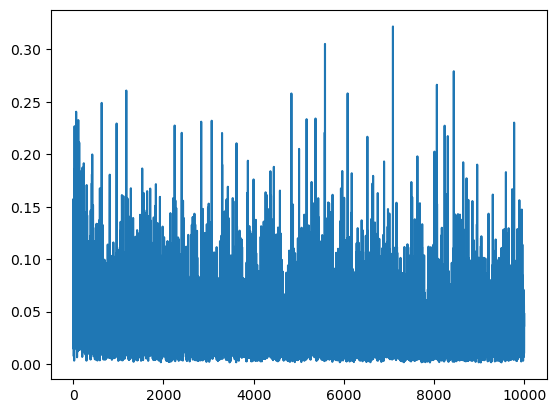

In [7]:
plt.plot(losses)

## Sampling

### Same thing as Model and Training section

Done Sampling - Model learned to extrapolate from tails to pole region


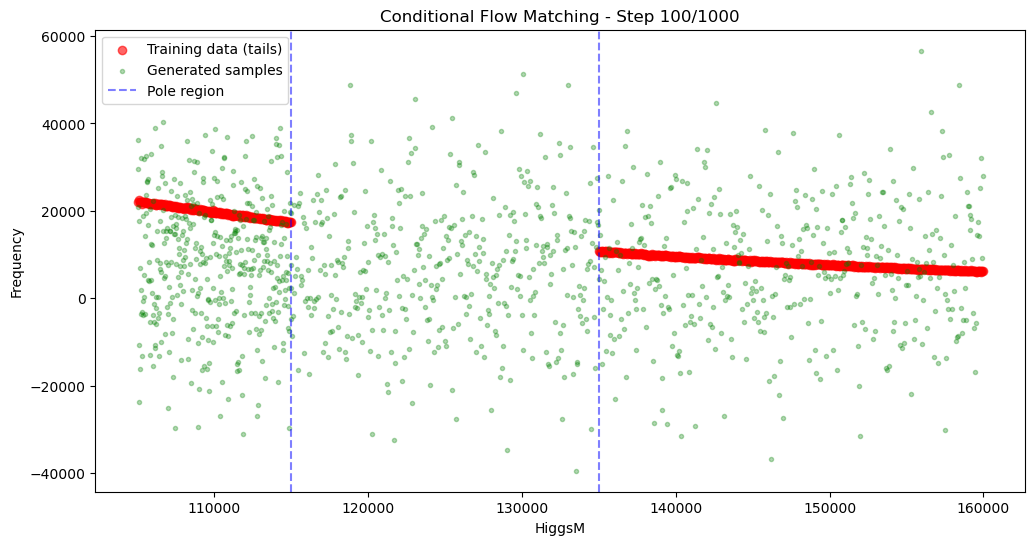

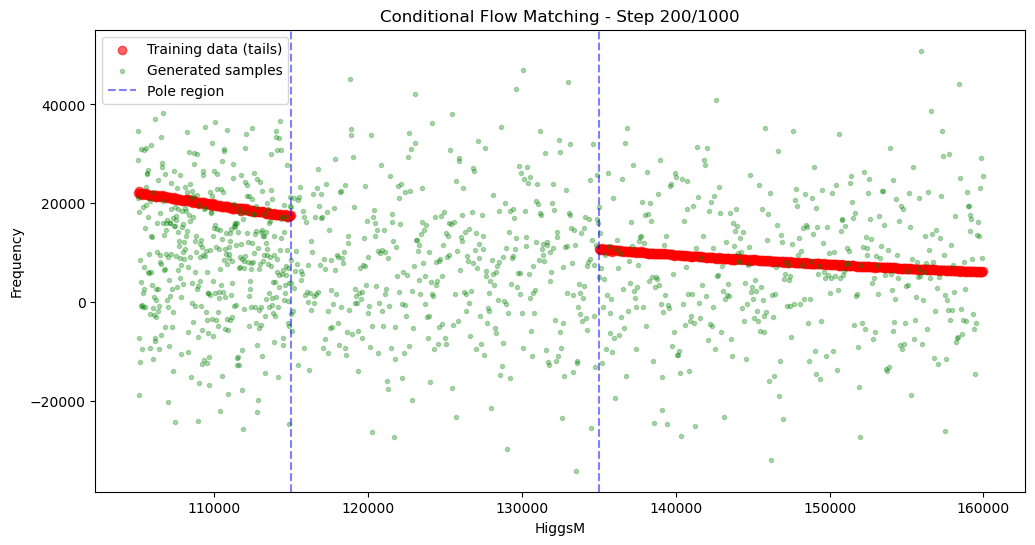

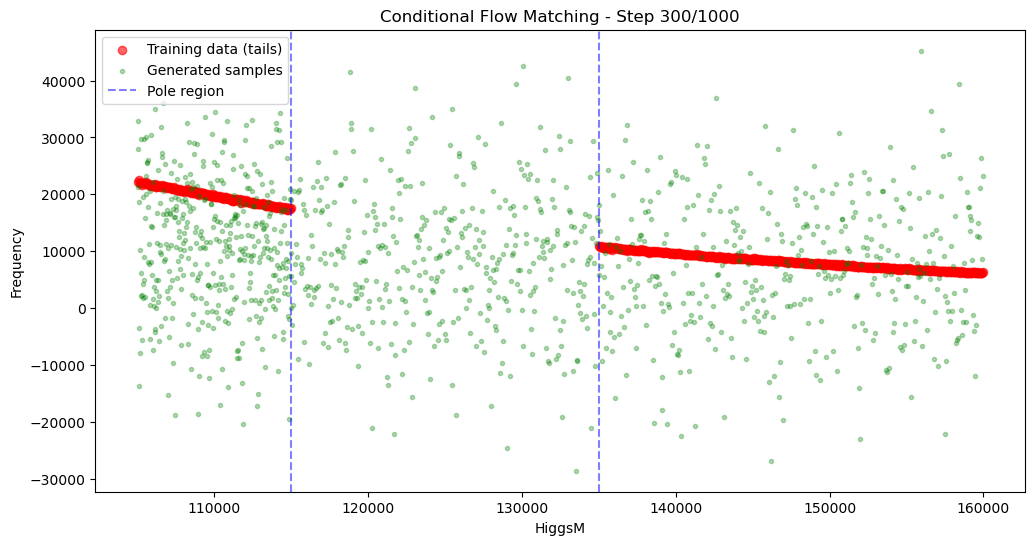

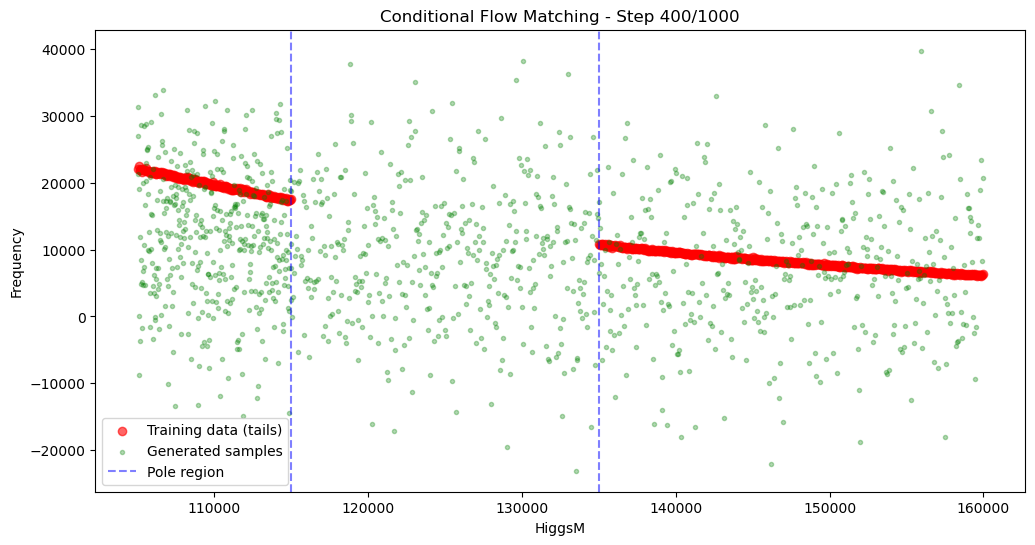

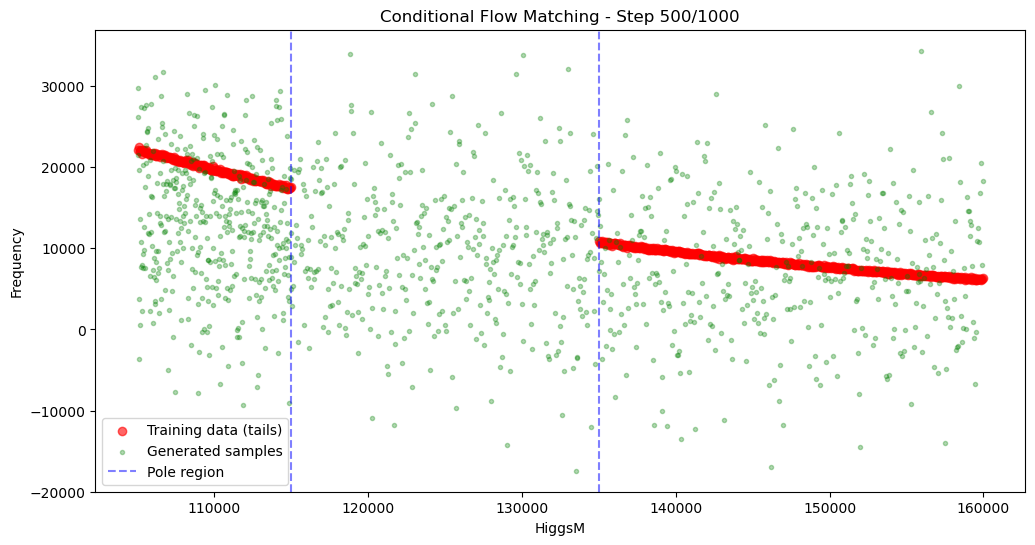

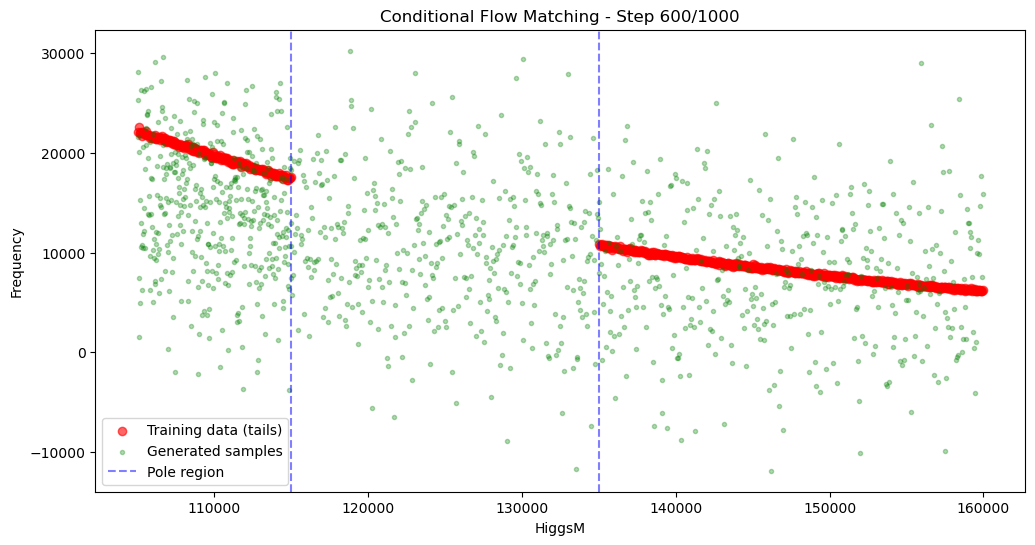

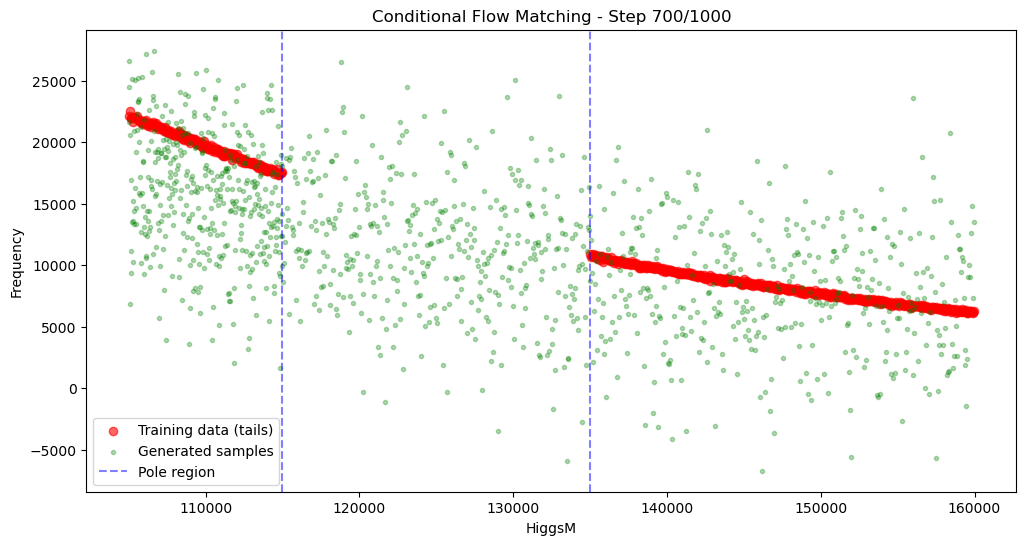

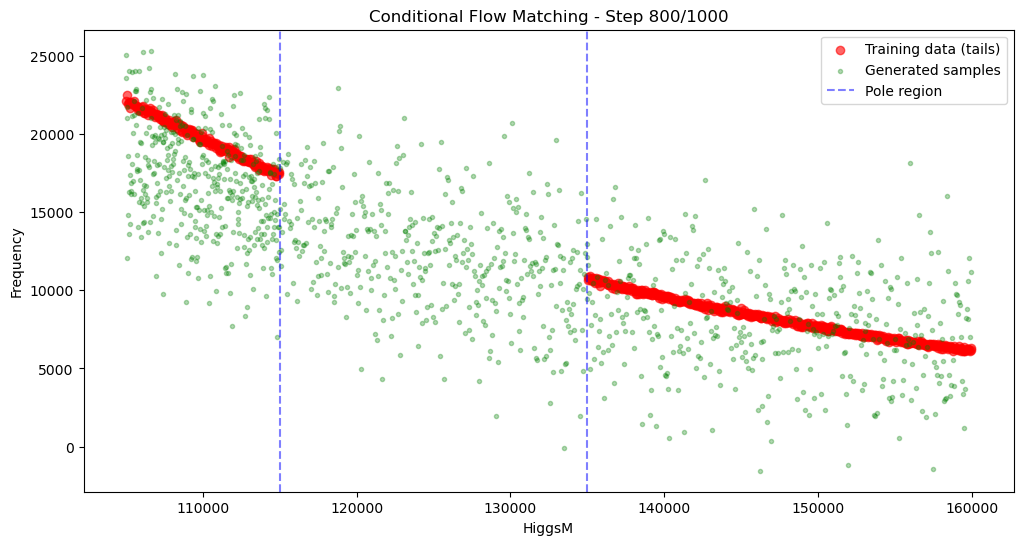

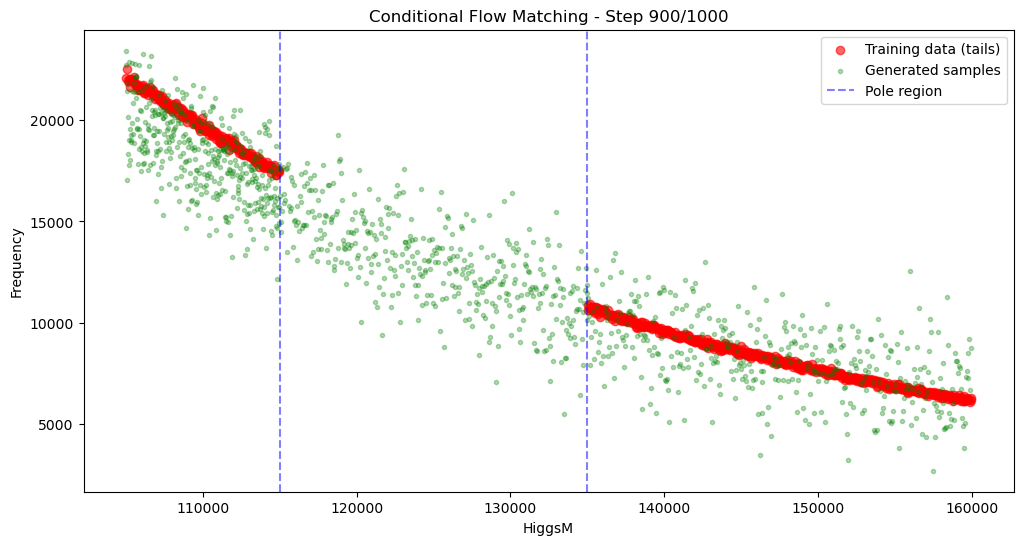

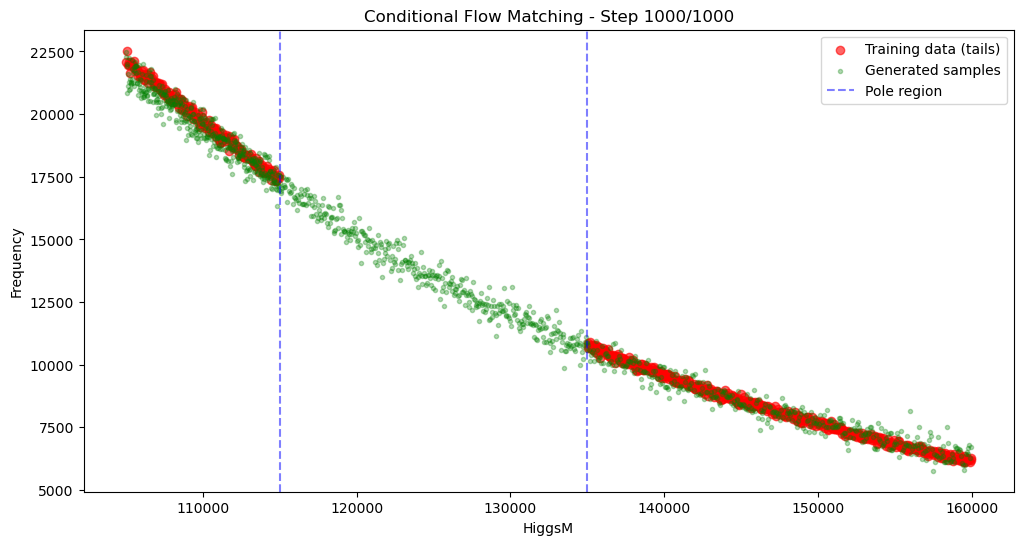

In [30]:
torch.manual_seed(42)
model.eval().requires_grad_(False)

# Gives the shape (number of points) of the pole region data
model_df_pole = model_df[~(mask1 | mask2)]
true_points = model_df_pole[['HiggsM', 'Frequency']].to_numpy()

# Sample across the full HiggsM range (tails + pole region)
# Ensures that the number of samples in the pole region matches the number of true points
num_samples_per_region = true_points.shape[0]   
steps = 1000

# Create HiggsM values for sampling: tails + pole region
HiggsM_tail_low = np.linspace(HiggsM_min, lower_bound, num_samples_per_region)
HiggsM_pole = np.linspace(lower_bound, upper_bound, num_samples_per_region)
HiggsM_tail_high = np.linspace(upper_bound, HiggsM_max, num_samples_per_region)
HiggsM_sample = np.concatenate([HiggsM_tail_low, HiggsM_pole, HiggsM_tail_high])

# Normalize HiggsM
HiggsM_sample_norm = (HiggsM_sample - HiggsM_min) / (HiggsM_max - HiggsM_min)

# Initialize noise
xt = torch.randn(len(HiggsM_sample), 1)
cond = torch.Tensor(HiggsM_sample_norm[:, None])

# Sampling process
plot_every = 100
for step, t in enumerate(torch.linspace(0, 1, steps), start=1):
    with torch.no_grad():
        pred = model(xt, t.expand(xt.size(0)), cond)
    xt = xt + (1 / steps) * pred
    if step % plot_every == 0:
        # Denormalize frequency predictions back to original scale
        xt_denorm = xt.detach().numpy() * (Freq_max - Freq_min) + Freq_min
        plt.figure(figsize=(12, 6))
        plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o", label="Training data (tails)", alpha=0.6)
        plt.scatter(HiggsM_sample, xt_denorm, color="green", marker=".", label="Generated samples", alpha=0.3)
        plt.axvline(lower_bound, color='blue', linestyle='--', alpha=0.5, label='Pole region')
        plt.axvline(upper_bound, color='blue', linestyle='--', alpha=0.5)
        plt.xlabel('HiggsM')
        plt.ylabel('Frequency')
        plt.legend()
        plt.title(f'Conditional Flow Matching - Step {step}/{steps}')
        # plt.show()

model.train().requires_grad_(True)
print("Done Sampling - Model learned to extrapolate from tails to pole region")


## KL Divergence calculation to assess quality of the model


In [36]:
pred_points = pd.DataFrame({'HiggsM': HiggsM_sample, 'Frequency': xt_denorm.flatten()})
lower_bound = 115000
upper_bound = 135000
pred_points_pole = pred_points[(pred_points['HiggsM'] >= lower_bound) & (pred_points['HiggsM'] <= upper_bound)]
pred_points_final = pred_points_pole[['HiggsM', 'Frequency']].to_numpy()

csv1 = pd.DataFrame(pred_points_final, columns=['HiggsM', 'Frequency'])
csv2 = pd.DataFrame(true_points, columns=['HiggsM', 'Frequency'])
csv1.to_csv('predicted_pole_region.csv', index=False)
csv2.to_csv('true_pole_region.csv', index=False)


# Ensuring that both arrays have the same shape for KL Divergence calculation by trimming both ends
counter = 0
if pred_points_final.shape > true_points.shape:
    while pred_points_final.shape != true_points.shape:
        if counter % 2 == 0: 
            pred_points_final = np.delete(pred_points_final, -1, axis=0)
            counter += 1
        else:
            pred_points_final = np.delete(pred_points_final, 0, axis=0)
        counter += 1

elif pred_points_final.shape < true_points.shape:
    while pred_points_final.shape != true_points.shape:
        if counter % 2 == 0: 
            true_points = np.delete(true_points, -1, axis=0)
            counter += 1
        else:
            true_points = np.delete(true_points, 0, axis=0)
            counter += 1
        

# Implement KL Divergence calculation
true_sum = np.sum(true_points[:, 1])
p = np.array(true_points[:, 1]) / true_sum
pred_sum = np.sum(pred_points_final[:, 1])
q = np.array(pred_points_final[:, 1]) / pred_sum

epsilon = 1e-10
p_smooth = p + epsilon
q_smooth = q + epsilon

print(p_smooth.shape, q_smooth.shape)

kl_divergence = np.sum(p_smooth * np.log(p_smooth / q_smooth))
print(f"KL Divergence between true and predicted distributions in the pole region: {kl_divergence}")






(400,) (400,)
KL Divergence between true and predicted distributions in the pole region: 0.00040264934279435577
